In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Read the aviator_dataset_clean.csv file
aviator_data = pd.read_csv("/content/drive/MyDrive/aviator/aviator_dataset_clean.csv")

# Display the first few rows of the dataset
aviator_data.head()


,color,mean,var,next_approximate,target
0,1.0,1.41,1.41,2.82,2.80
1,1.0,4.67,2.70,7.38,6.55
2,0.0,3.83,1.71,5.54,1.10
3,0.0,1.08,1.79,2.87,1.06
4,0.0,1.47,1.47,2.94,1.88


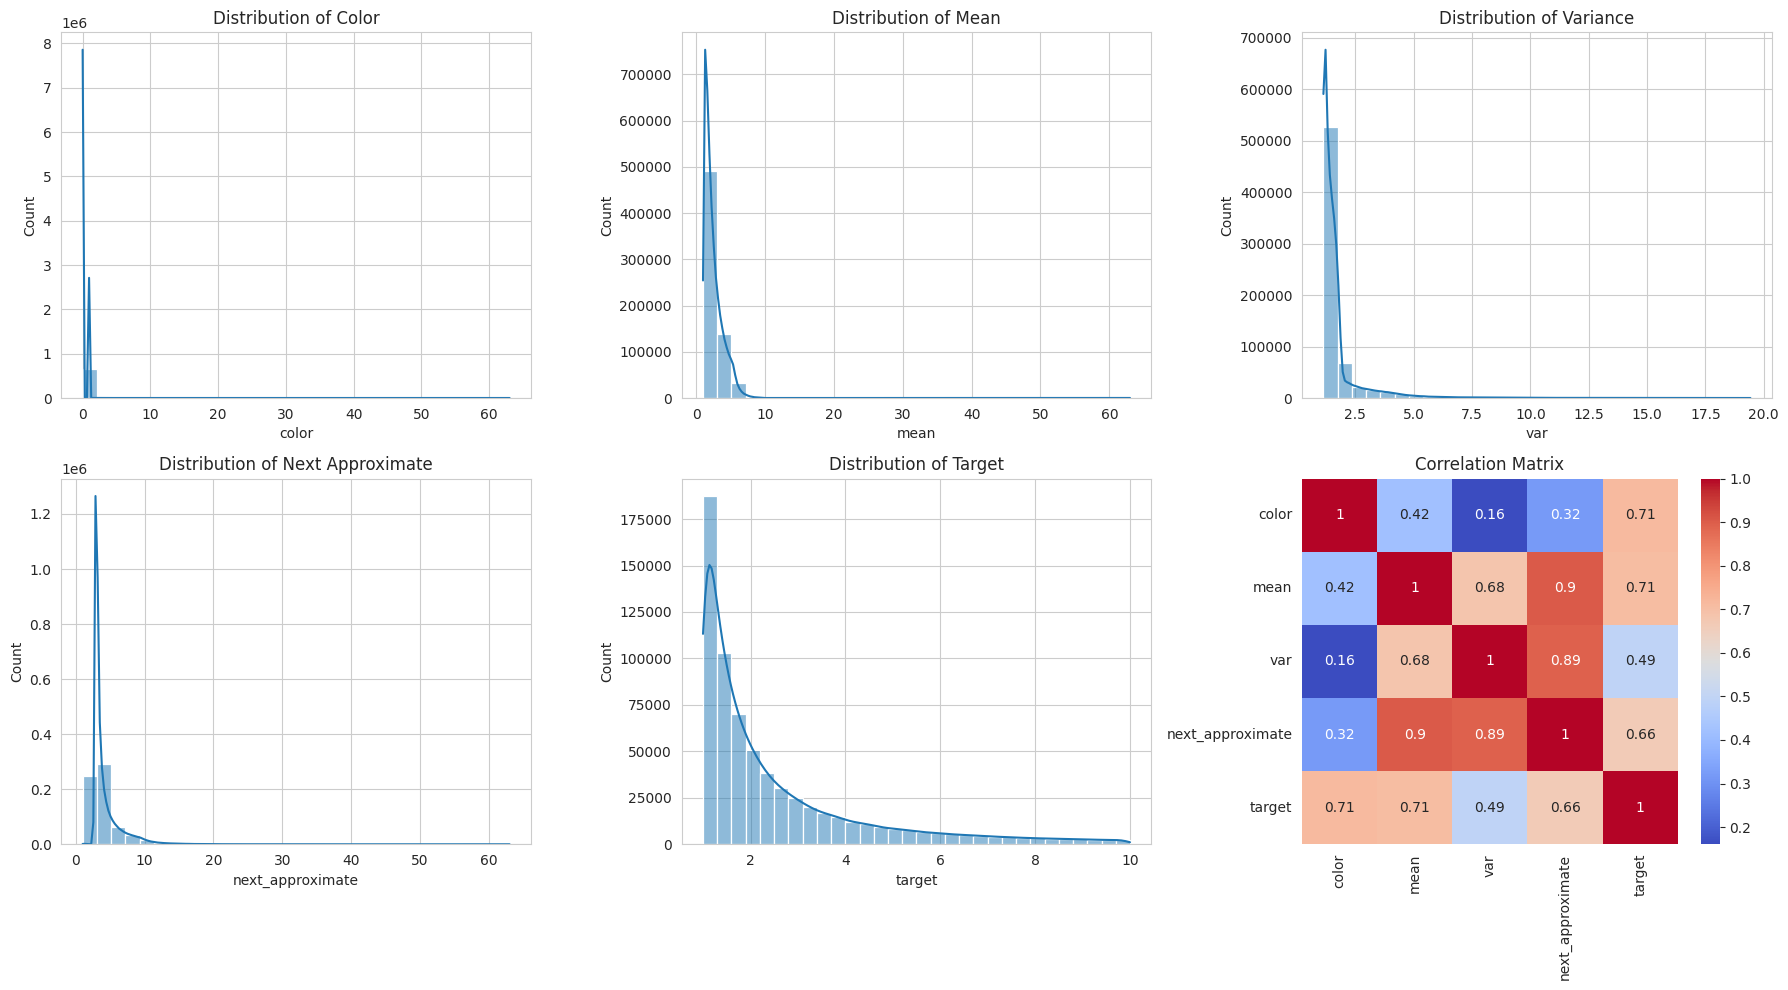

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting up the visualization style
sns.set_style("whitegrid")

# Plotting the distributions of the dataset columns
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

sns.histplot(aviator_data['color'], ax=ax[0, 0], bins=30, kde=True)
ax[0, 0].set_title('Distribution of Color')

sns.histplot(aviator_data['mean'], ax=ax[0, 1], bins=30, kde=True)
ax[0, 1].set_title('Distribution of Mean')

sns.histplot(aviator_data['var'], ax=ax[0, 2], bins=30, kde=True)
ax[0, 2].set_title('Distribution of Variance')

sns.histplot(aviator_data['next_approximate'], ax=ax[1, 0], bins=30, kde=True)
ax[1, 0].set_title('Distribution of Next Approximate')

sns.histplot(aviator_data['target'], ax=ax[1, 1], bins=30, kde=True)
ax[1, 1].set_title('Distribution of Target')

# Displaying the correlations between columns
sns.heatmap(aviator_data.corr(), annot=True, cmap="coolwarm", ax=ax[1, 2])
ax[1, 2].set_title('Correlation Matrix')

plt.tight_layout()
plt.show()


In [4]:
# 1. Checking for missing values in the dataset
missing_values = aviator_data.isnull().sum()

# 2. Splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Using 80% of the data for training and 20% for testing
X = aviator_data.drop('target', axis=1)
y = aviator_data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Normalizing the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

missing_values


color                  0
mean                   0
var                    0
next_approximate       0
target              1045
dtype: int64

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Designing the Neural Network Architecture
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)  # Single neuron for regression output
])


In [6]:
model

In [7]:
model.compile(
    optimizer='adam',
    loss='mse',          # Mean Squared Error for regression tasks
    metrics=['mae']      # Mean Absolute Error for regression performance
)


In [8]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/path_to_directory/my_aviator_model.h5')

Robust model

The program:

1. Allows users to start with two initial multipliers.
2. Predicts the next value based on the latest two multipliers.
3. Accepts the observed real value for the prediction.
4. Updates the multipliers by shifting the second to the first and setting the observed value as the new second multiplier.
5. Continues this loop until the user decides to exit.
6. Checks for data accumulation and potentially retrains the model.
7. Handles various user inputs and errors gracefully.
8. Logs important activities for debugging and reference.

In [9]:

import pandas as pd
import numpy as np
import logging
import shutil
import os
from datetime import datetime
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Configuration Constants
FILE_PATH = '/content/drive/MyDrive/aviator/aviator_dataset_clean.csv'
BACKUP_PATH = '/content/drive/MyDrive/aviator/aviator_dataset_backup.csv'
LOG_PATH = 'aviator_log.txt'
RETRAIN_THRESHOLD = 0.55
DATA_ACCUMULATION_LIMIT = 100
MIN_MULTIPLIER = 0
MAX_MULTIPLIER = 1000

# Setting up logging
logging.basicConfig(filename=LOG_PATH, level=logging.INFO,
                    format='%(asctime)s:%(levelname)s:%(message)s')

def backup_data(original_path, backup_path):
    """Backup the original data."""
    shutil.copy2(original_path, backup_path)
    logging.info("Data backed up.")

def load_latest_data(filepath):
    """Load the latest dataset."""
    return pd.read_csv(filepath)

# Define utility functions
def color_from_value(value):
    return 1 if value >= 2 else 0

def predict_next_value(model, first_multiplier, second_multiplier, scaler):
    mean_val = (first_multiplier + second_multiplier) / 2
    var_val = sum((x - mean_val)**2 for x in [first_multiplier, second_multiplier]) / 2
    next_approx = mean_val + var_val
    color_val = color_from_value(next_approx)

    # Scaling the input values
    scaled_values = scaler.transform([[color_val, mean_val, var_val, next_approx]])
    predicted_next_val = model.predict(scaled_values)[0][0]
    return predicted_next_val

def append_new_data_to_csv(filepath, new_data):
    """Append new data to the CSV file."""
    with open(filepath, 'a') as f:
        for data_row in new_data:
            f.write(f"\n{','.join(map(str, data_row))}")
    logging.info("New data appended to CSV.")

def retrain_model_on_new_data(filepath, model_path):
    """Retrain the model with new data."""
    data = load_latest_data(filepath)
    X = data.drop('target', axis=1)
    y = data['target']

    # Splitting data for training/testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scaling the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Load the current best model
    current_model = load_model(model_path)
    current_preds = current_model.predict(X_test_scaled)
    current_mae = mean_absolute_error(y_test, current_preds)

    # Design a new model for retraining
    new_model = load_model(model_path)

    # Fit the new model
    new_model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Evaluate the new model
    new_preds = new_model.predict(X_test_scaled)
    new_mae = mean_absolute_error(y_test, new_preds)

    # If the new model is better, save it. Else, continue with the old model.
    if new_mae < current_mae:
        timestamp = datetime.now().strftime('%Y%m%d%H%M%S')
        new_model_path = model_path.replace('.h5', f'_{timestamp}.h5')
        new_model.save(new_model_path)
        logging.info(f"New model saved at {new_model_path} with MAE: {new_mae}.")
        return new_model_path, scaler
    else:
        logging.info("Old model performs better. Continuing with it.")
        return model_path, scaler

def main():
    logging.info("Starting the Aviator Prediction Program.")

    # Backup the original dataset
    backup_data(FILE_PATH, BACKUP_PATH)

    # Load initial data and model
    aviator_data = load_latest_data(FILE_PATH)
    model_path = '/content/drive/MyDrive/path_to_directory/my_aviator_model.h5'  # Adjust this to the location of your best model
    model = load_model(model_path)

    # Scaling the features for prediction
    X = aviator_data.drop('target', axis=1)
    scaler = StandardScaler()
    scaler.fit(X)

    print("Welcome to the Aviator Prediction Program!")
    print("Initially, please provide two multipliers to begin the predictions.")
    first_multiplier = float(input("Enter the first multiplier: "))
    second_multiplier = float(input("Enter the second multiplier: "))

    # Start the interactive loop
    new_data = []
    while True:
        try:
            predicted_value = predict_next_value(model, first_multiplier, second_multiplier, scaler)
            print(f"Predicted Next Value: {predicted_value}")

            real_value_input = input(f"Enter the observed real value for the predicted value: ")

            if real_value_input.lower() == 'exit':
                print("Exiting the Aviator Prediction Program.")
                break

            real_value = float(real_value_input)
            new_data.append([first_multiplier, second_multiplier, predicted_value, real_value])

            # Updating the multipliers for the next iteration
            first_multiplier = second_multiplier
            second_multiplier = real_value

            if len(new_data) >= DATA_ACCUMULATION_LIMIT:
                append_new_data_to_csv(FILE_PATH, new_data)
                model_path, scaler = retrain_model_on_new_data(FILE_PATH, model_path)
                model = load_model(model_path)
                new_data = []

        except ValueError as e:
            print(f"Invalid input: {e}. Please enter valid multipliers or type 'exit' to quit.")
        except Exception as e:
            logging.error(f"Unexpected error: {e}")
            print("An unexpected error occurred. Check the logs for more details.")
            break

if __name__ == "__main__":
    main()

Welcome to the Aviator Prediction Program!
Initially, please provide two multipliers to begin the predictions.
Enter the first multiplier: 3.83
Enter the second multiplier: 1.38


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 161ms/step
Predicted Next Value: 3.491827964782715
Enter the observed real value for the predicted value: 3.28
1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 3.0373992919921875
Enter the observed real value for the predicted value: 3.06
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 3.1157965660095215
Enter the observed real value for the predicted value: 3.96
1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 3.2109365463256836
Enter the observed real value for the predicted value: 9.07
1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 6.356328010559082
Enter the observed real value for the predicted value: 5.40
1/1 [==============================] - 0s 26ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 2.679252862930298
Enter the observed real value for the predicted value: 1.44
1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 6.091113567352295
Enter the observed real value for the predicted value: 1.10
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 1.7757203578948975
Enter the observed real value for the predicted value: 3.44
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 2.788930654525757
Enter the observed real value for the predicted value: 19.65
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 2.257175922393799
Enter the observed real value for the predicted value: 4.92
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 2.257175922393799
Enter the observed real value for the predicted value: 1.14
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 3.0130417346954346
Enter the observed real value for the predicted value: 2.33
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 2.6051316261291504
Enter the observed real value for the predicted value: 3.93
1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 3.5082013607025146
Enter the observed real value for the predicted value: 1.66
1/1 [==============================] - 0s 22ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Predicted Next Value: 3.789278507232666
Enter the observed real value for the predicted value: exit
Exiting the Aviator Prediction Program.
